# **Dataset 1**

### **Import Packages**

In [32]:
import multiprocessing
import subprocess
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import sys

sys.path.append(os.path.abspath("../src"))

from generation.data_synthesizer import ds_generate_data
from generation.synthetic_data_vault import sdv_generate_data
from evaluation.utility import run_utility_eval
from evaluation.resemblance import pairwise_correlation_diff, jsd, wd
from evaluation.privacy import dcr, nndr, mia
from sklearn.preprocessing import LabelEncoder

### **Exploratory Data Analysis**

In [33]:
data_path = "../data/original_data/1_kalboard_lms/1_kalboard_lms.csv"
original_data = pd.read_csv(data_path)
original_data.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [34]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   gender                    480 non-null    object
 1   NationalITy               480 non-null    object
 2   PlaceofBirth              480 non-null    object
 3   StageID                   480 non-null    object
 4   GradeID                   480 non-null    object
 5   SectionID                 480 non-null    object
 6   Topic                     480 non-null    object
 7   Semester                  480 non-null    object
 8   Relation                  480 non-null    object
 9   raisedhands               480 non-null    int64 
 10  VisITedResources          480 non-null    int64 
 11  AnnouncementsView         480 non-null    int64 
 12  Discussion                480 non-null    int64 
 13  ParentAnsweringSurvey     480 non-null    object
 14  ParentschoolSatisfaction  

In [35]:
original_data.isnull().sum()

gender                      0
NationalITy                 0
PlaceofBirth                0
StageID                     0
GradeID                     0
SectionID                   0
Topic                       0
Semester                    0
Relation                    0
raisedhands                 0
VisITedResources            0
AnnouncementsView           0
Discussion                  0
ParentAnsweringSurvey       0
ParentschoolSatisfaction    0
StudentAbsenceDays          0
Class                       0
dtype: int64

In [36]:
original_data.nunique()

gender                       2
NationalITy                 14
PlaceofBirth                14
StageID                      3
GradeID                     10
SectionID                    3
Topic                       12
Semester                     2
Relation                     2
raisedhands                 82
VisITedResources            89
AnnouncementsView           88
Discussion                  90
ParentAnsweringSurvey        2
ParentschoolSatisfaction     2
StudentAbsenceDays           2
Class                        3
dtype: int64

In [37]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

gender ['M' 'F']
NationalITy ['KW' 'lebanon' 'Egypt' 'SaudiArabia' 'USA' 'Jordan' 'venzuela' 'Iran'
 'Tunis' 'Morocco' 'Syria' 'Palestine' 'Iraq' 'Lybia']
PlaceofBirth ['KuwaIT' 'lebanon' 'Egypt' 'SaudiArabia' 'USA' 'Jordan' 'venzuela' 'Iran'
 'Tunis' 'Morocco' 'Syria' 'Iraq' 'Palestine' 'Lybia']
StageID ['lowerlevel' 'MiddleSchool' 'HighSchool']
GradeID ['G-04' 'G-07' 'G-08' 'G-06' 'G-05' 'G-09' 'G-12' 'G-11' 'G-10' 'G-02']
SectionID ['A' 'B' 'C']
Topic ['IT' 'Math' 'Arabic' 'Science' 'English' 'Quran' 'Spanish' 'French'
 'History' 'Biology' 'Chemistry' 'Geology']
Semester ['F' 'S']
Relation ['Father' 'Mum']
ParentAnsweringSurvey ['Yes' 'No']
ParentschoolSatisfaction ['Good' 'Bad']
StudentAbsenceDays ['Under-7' 'Above-7']
Class ['M' 'L' 'H']


<Axes: xlabel='Class', ylabel='Count'>

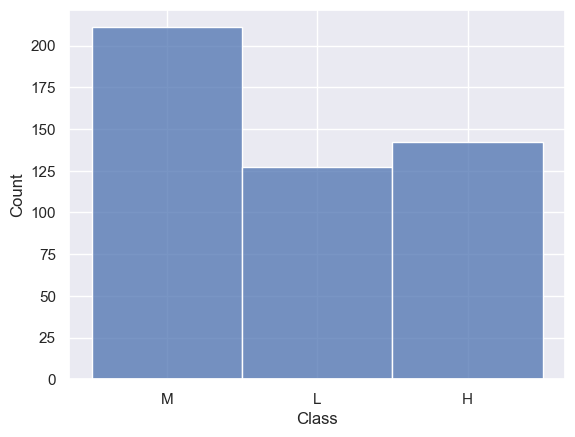

In [38]:
# Check class distribution
sns.histplot(original_data['Class'])

### **Synthetic Data Generation**

In [39]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

# Number of samples to generate
n = 5000

original_data_path = "../data/original_data/1_kalboard_lms/"
train_file = os.path.join(original_data_path, "train_data.csv")
test_file = os.path.join(original_data_path, "test_data.csv")

# Prüfen, ob beide Dateien existieren
if os.path.isfile(train_file) and os.path.isfile(test_file):
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    print("Train and test data loaded.")
else:
    train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
    train_data.to_csv(train_file, index=False)
    test_data.to_csv(test_file, index=False)
    print("Train and test data saved.")

Train and test data loaded.


In [40]:
synth_path = "../data/synthetic_data/1_kalboard_lms/"
csv_files = [file for file in os.listdir(synth_path) if file.endswith(".csv")]
dataset_name = '1_kalboard_lms'

if len(csv_files) == 0:

    # Use train_data.csv to fit SDG models and generate synthetic data
    data_path = original_data_path + "train_data.csv"
    arguments = [data_path, str(n), dataset_name]

    print("Sampling synthpop...")
    result = subprocess.run(['Rscript', '../src/generation/synthpop.R',   *arguments], capture_output=True, text=True)

    print("Sampling DataSynthesizer...")
    ds_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)

    sdv_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)
else:
    print("Synthetic data already exists.")

Synthetic data already exists.


Encode all categorical columns of both original (train+test) data and synthetic data using label encoding

In [41]:
# Load synthetic data
synthpop = pd.read_csv(synth_path + "synthpop.csv")
ds = pd.read_csv(synth_path + "ds.csv")
tvae = pd.read_csv(synth_path + "tvae.csv")
gaussian_copula = pd.read_csv(synth_path + "gaussian_copula.csv")
copula_gan = pd.read_csv(synth_path + "copula_gan.csv")
ctgan = pd.read_csv(synth_path + "ctgan.csv")

# Encode categorical columns as integers
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le

In [42]:
train_data.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,1,3,3,1,5,0,5,1,1,70,83,70,23,1,1,1,2
1,0,3,3,2,2,0,3,0,1,21,10,28,20,0,1,0,1
2,0,3,3,2,0,1,7,0,1,70,88,55,40,1,1,1,0
3,1,3,3,2,1,1,10,1,1,72,64,59,89,1,1,1,0
4,1,4,4,2,1,0,8,1,0,15,6,32,40,1,1,1,0


### **Utility Evaluation**

Run random forest classifier for utility evaluation

In [43]:
# Set target column
target_col = 'Class'
synth_datasets = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]

In [44]:
rf_results = {}
rf_df = pd.read_csv("../data/results/tables/rf.csv")
rows = []

if (rf_df["Dataset"] == 1).any():
    print("Entry for '1_kalboard_lms' already exists")
else:
    # Run utility evaluation using random forest for each model and store results
    for i, synth_dataset in enumerate(synth_datasets):
        rf_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "random_forest")
        
        acc_diff = rf_results[model_names[i]]["acc_diff"]
        f1_diff = rf_results[model_names[i]]["f1_diff"]
        roc_auc_diff = rf_results[model_names[i]]["roc_auc_diff"]

        rows.append([1,model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rf_df = pd.DataFrame(rows, columns=["Dataset", "Model", "Accuracy Difference", "F1 Score Difference", "ROC AUC Difference"])
    rf_df.to_csv("../data/results/tables/rf.csv", index=False)
    rf_df.head()


Entry for '1_kalboard_lms' already exists


Run logistic regression for utility evaluation

In [45]:
lr_results = {}
rows = []
lr_df = pd.read_csv("../data/results/tables/lr.csv")

if (lr_df["Dataset"] == 1).any():
    print("Entry for '1_kalboard_lms' already exists")
else:
    # Run utility evaluation using logistic regression for each model and store results
    for i, synth_dataset in enumerate(synth_datasets):
        lr_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "logistic_regression")

        acc_diff = lr_results[model_names[i]]["acc_diff"]
        f1_diff = lr_results[model_names[i]]["f1_diff"]
        roc_auc_diff = lr_results[model_names[i]]["roc_auc_diff"]

        rows.append([1,model_names[i], acc_diff, f1_diff, roc_auc_diff])

    lr_df = pd.DataFrame(rows, columns=["Dataset", "Model", "Accuracy Difference", "F1 Score Difference", "ROC AUC Difference"])
    lr_df.to_csv("../data/results/tables/lr.csv", index=False)
    lr_df.head()


Entry for '1_kalboard_lms' already exists


Run multilayer perceptron (MLP)

In [46]:
mlp_results = {}
rows = []
mlp_df = pd.read_csv("../data/results/tables/mlp.csv")

if (mlp_df["Dataset"] == 1).any():
    print("Entry for '1_kalboard_lms' already exists")
else:
    # Run utility evaluation using MLP for each model and store results
    for i, synth_dataset in enumerate(synth_datasets):
        mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "multilayer_perceptron")

        acc_diff = mlp_results[model_names[i]]["acc_diff"]
        f1_diff = mlp_results[model_names[i]]["f1_diff"]
        roc_auc_diff = mlp_results[model_names[i]]["roc_auc_diff"]

        rows.append([1,model_names[i], acc_diff, f1_diff, roc_auc_diff])

    mlp_df = pd.DataFrame(rows, columns=["Dataset", "Model", "Accuracy Difference", "F1 Score Difference", "ROC AUC Difference"])
    mlp_df.to_csv("../data/results/tables/mlp.csv", index=False)
    mlp_df.head()

Entry for '1_kalboard_lms' already exists


### **Resemblance**

Run multiple resemblance metrics: Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance

- Correlation distance diff : lower values are better
- JSD in [0,1] range: lower values are better
- WD: lower values are better


**Difference in pairwise correlation:**

In [47]:
rows = []
corr_diff_df = pd.read_csv("../data/results/tables/corr_diff.csv")

if (corr_diff_df["Dataset"] == 1).any():
    print("Entry for '1_kalboard_lms' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = pairwise_correlation_diff(train_data, synth_dataset)
        rows.append([1,model_names[i], result])

    corr_diff_df = pd.DataFrame(rows, columns=["Dataset", "Model", "Pairwise Corr Diff"])
    corr_diff_df.to_csv("../data/results/tables/corr_diff.csv", index=False)
    corr_diff_df.head()

Entry for '1_kalboard_lms' already exists


**Jensen-Shannon Divergence**

In [48]:
rows = []
jsd_df = pd.read_csv("../data/results/tables/jsd.csv")

if (jsd_df["Dataset"] == 1).any():
    print("Entry for '1_kalboard_lms' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = jsd(train_data, synth_dataset)
        rows.append([1,model_names[i], result])

    jsd_df = pd.DataFrame(rows, columns=["Dataset", "Model", "JSD Diff"])
    jsd_df.to_csv("../data/results/tables/jsd.csv", index=False)
    jsd_df.head()

Entry for '1_kalboard_lms' already exists


**Wasserstein Distance**

In [49]:
wd_results = {}
rows = []
wd_df = pd.read_csv("../data/results/tables/wd.csv")

if (wd_df["Dataset"] == 1).any():
    print("Entry for '1_kalboard_lms' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        wd_results[model_names[i]] = wd(train_data, synth_dataset)
        rows.append([1,model_names[i], wd_results[model_names[i]]])

    wd_df = pd.DataFrame(rows, columns=["Dataset", "Model", "WD Diff"])
    wd_df.to_csv("../data/results/tables/wd.csv", index=False)
    wd_df.head()

Entry for '1_kalboard_lms' already exists


### **Privacy**

Run privacy evaluation using Distance to closest Record (DCR), Nearest Neighbour Difference Ratio (NNDR) and Membership Inference Attack (MIA)

- **DCR**: a value of zero indicates that the synthetic record is an identical copy of the original
one -> leak of real information, higher values indicate more privacy

- **NNDR**: ratio is within [0,1], higher values indicate better privacy

- **MIA**: both accuracy and precision should be below 0.5 for all thresholds for strong privacy preservation

**Distance to closest record (DCR)**

In [50]:
rows = []
dcr_df = pd.read_csv("../data/results/tables/dcr.csv")

if (dcr_df["Dataset"] == 1).any():
    print("Entry for '1_kalboard_lms' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, save_hist=True)
        result_within_real = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, within="Original", save_hist=False)
        result_within_synth = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, within="Synthetic", save_hist=False)
        rows.append([1,model_names[i], result, result_within_real, result_within_synth])

    dcr_df = pd.DataFrame(rows, columns=["Dataset", "Model", "DCR 5th Percentile", "DCR 5th Percentile (within Real)", "DCR 5th Percentile (within Synthetic)"])
    dcr_df.to_csv("../data/results/tables/dcr.csv", index=False)
    dcr_df.head()   

Entry for '1_kalboard_lms' already exists


**Nearest Neighbor distance ratio (NNDR)**

In [51]:
rows = []
nndr_df = pd.read_csv("../data/results/tables/nndr.csv")

if (nndr_df["Dataset"] == 1).any():
    print("Entry for '1_kalboard_lms' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = nndr(train_data, synth_dataset)
        result_within_real = nndr(train_data, synth_dataset, within="Original")
        result_within_synth = nndr(train_data, synth_dataset, within="Synthetic")
        rows.append([1,model_names[i], result, result_within_real, result_within_synth])

    nndr_df = pd.DataFrame(rows, columns=["Dataset", "Model", "NNDR 5th percentile", "NNDR 5th percentile (within Real)", "NNDR 5th percentile (within Synthetic)"])
    nndr_df.to_csv("../data/results/tables/nndr.csv", index=False)
    nndr_df.head()  

Entry for '1_kalboard_lms' already exists


**Membership Inference Attack (MIA)**

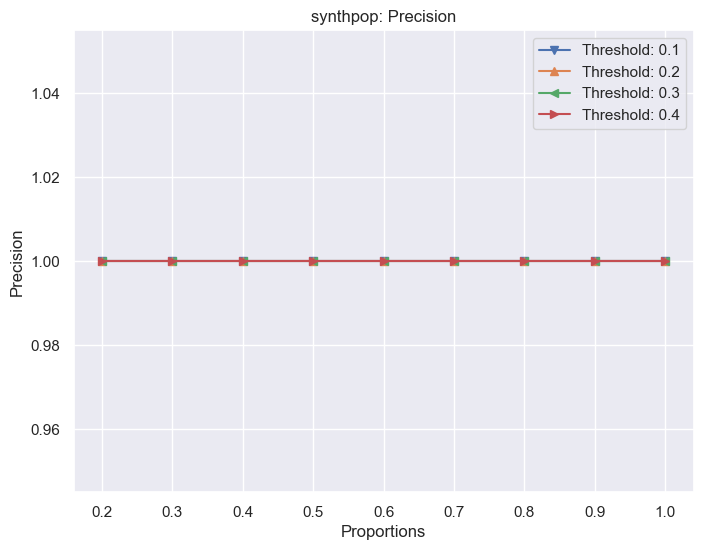

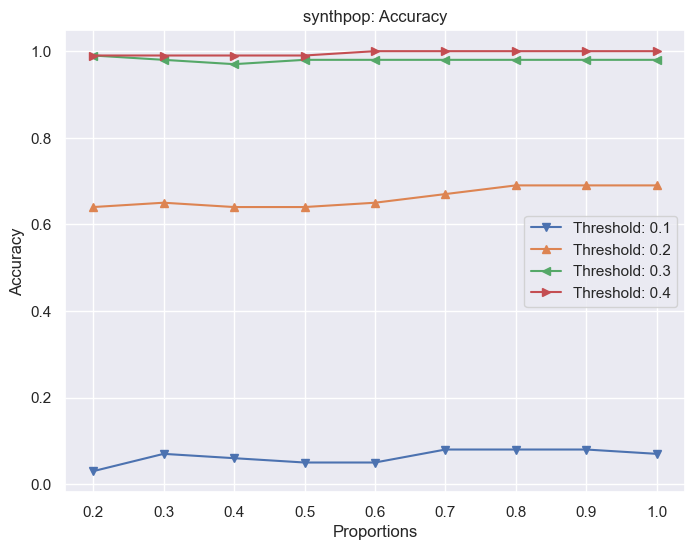

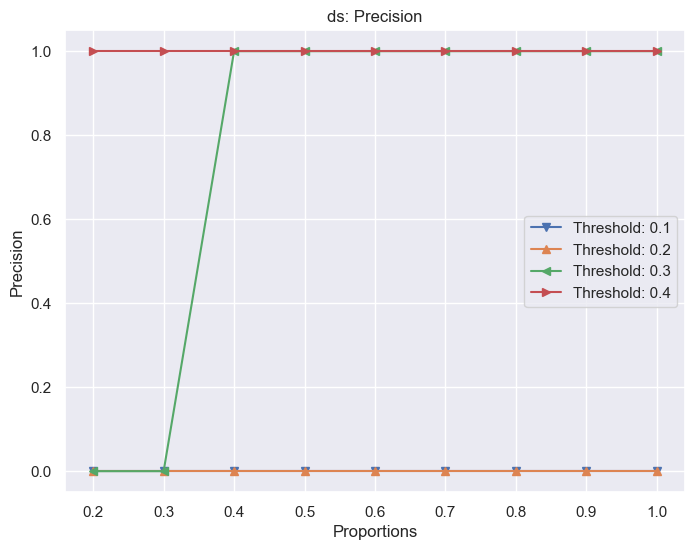

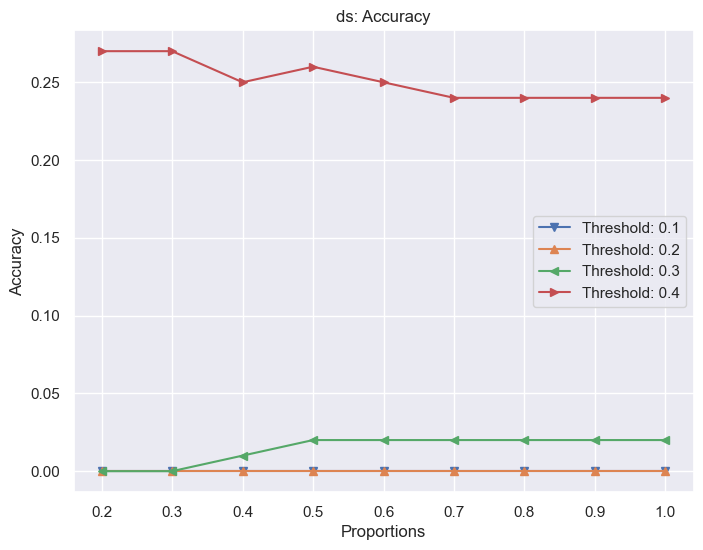

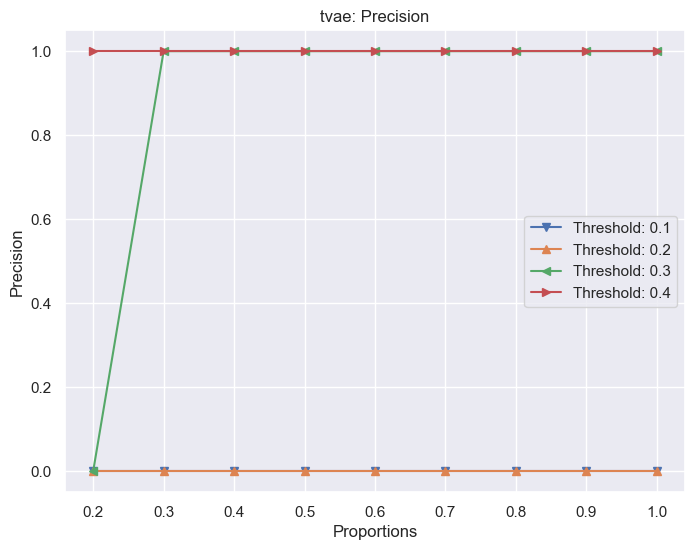

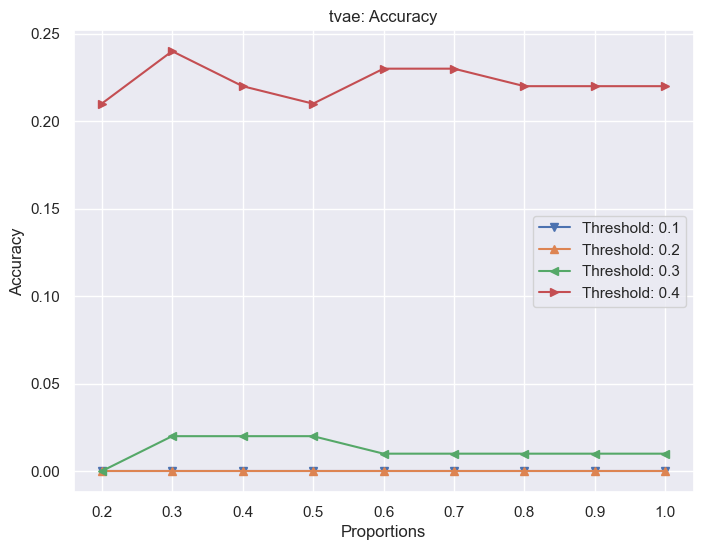

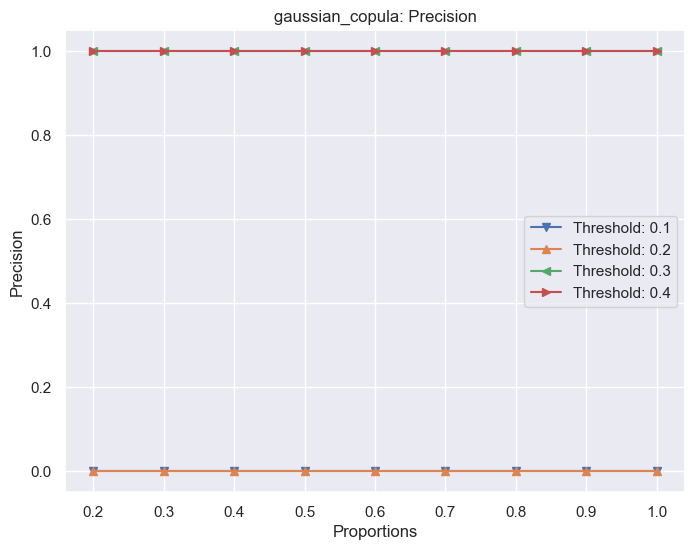

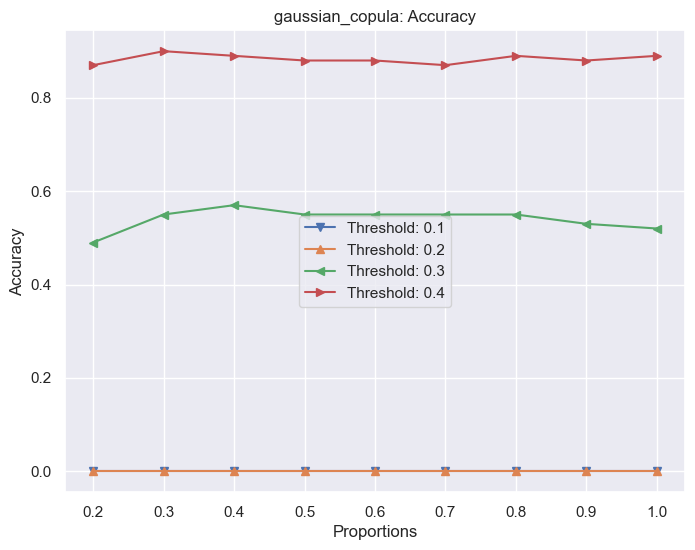

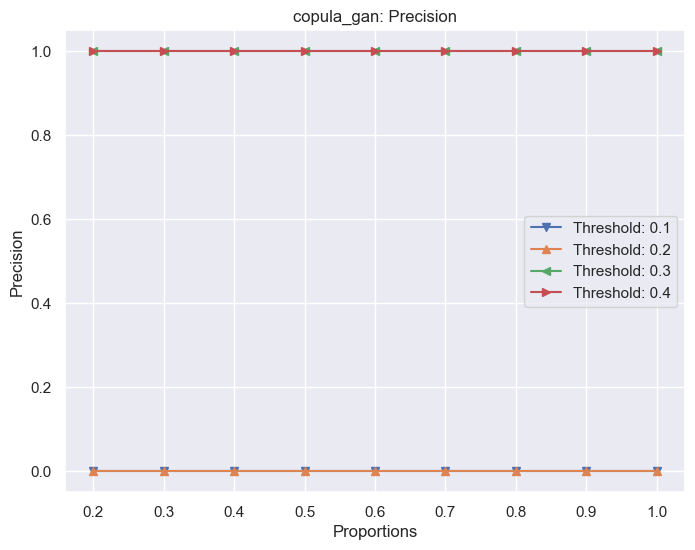

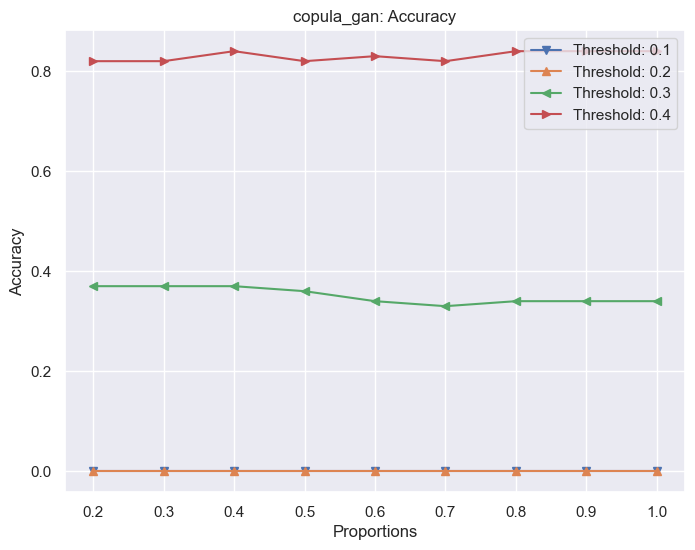

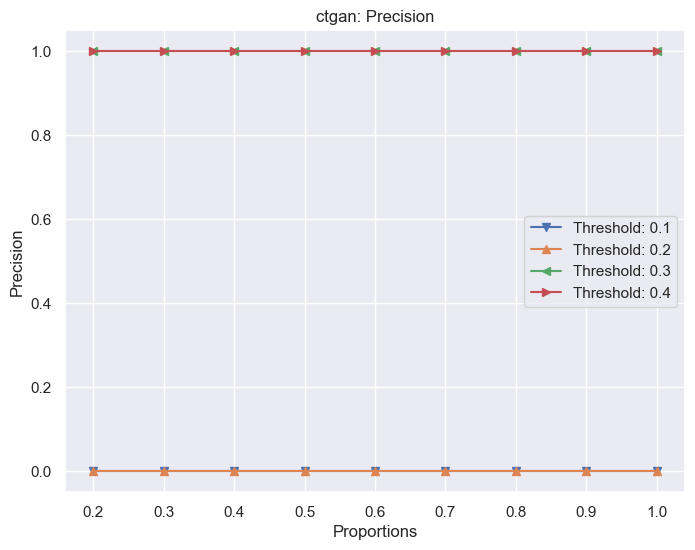

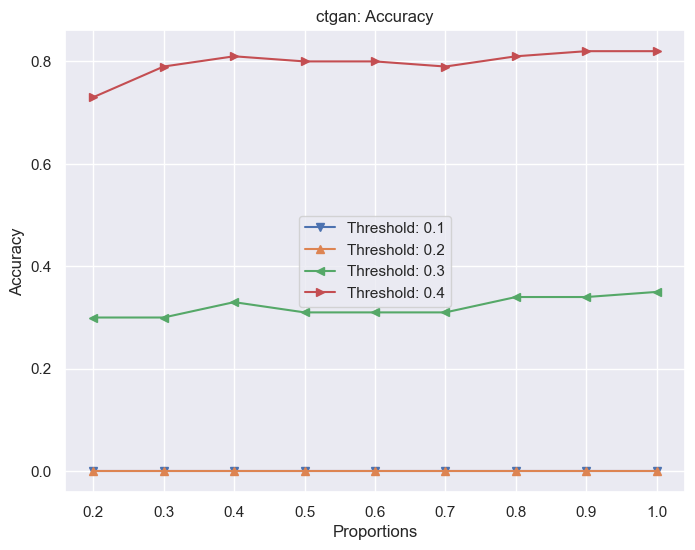

In [52]:
mia_results = {}
if (os.path.isfile("../data/results/plots/mia/1_kalboard_lms/ds_mia_accuracy.png")):
    print("MIA results already exist.")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        mia_results[model_names[i]] = mia(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, save_plts=True)